In [40]:
from mangaki.utils.svd import MangakiSVD
import numpy as np
import pandas 
from mangaki.utils.values import rating_values

ratings = pandas.read_csv('../data/ratings.csv', header=None).as_matrix()
works=pandas.read_csv('../data/works.csv', header=None).as_matrix()




In [2]:
svd =MangakiSVD(10)
X=ratings[:,0:2]
Y=[rating_values[rating] for rating in ratings[:,2]]
nb_users=X[:,0].max()+1
nb_items=X[:,1].max()+1
svd.set_parameters(nb_users,nb_items)
svd.fit(X,Y)

Computing M: (1710 × 8347)
fill and center matrix [849 ms]
Shapes (1710, 10) (10,) (10, 8347)
factor matrix [26357 ms]


<IPython.core.display.Javascript object>


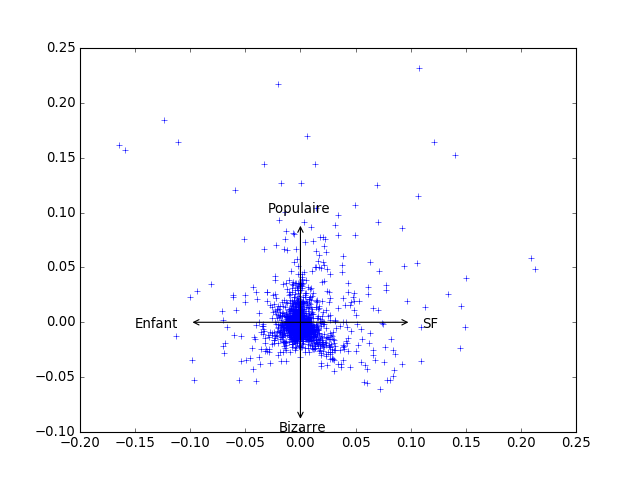

In [28]:
#Graphique pour les utilisateurs
%matplotlib notebook
import matplotlib.pyplot as plt

plt.clf()

#les axes
plt.annotate('', xy=(0, 0.09), xytext=(0, -0.09),arrowprops={'arrowstyle': '<->'})
plt.annotate('', xy=(0.1, 0), xytext=(-0.1, 0),arrowprops={'arrowstyle': '<->'})
#les annotations
plt.text(-0.03, 0.1, 'Populaire')
plt.text(-0.02, -0.1, 'Bizarre')
plt.text(-0.15, -0.005, 'Enfant')
plt.text(0.11, -0.005, 'SF')

plt.plot(svd.VT[0,:],svd.VT[1,:],'+b') 

<IPython.core.display.Javascript object>


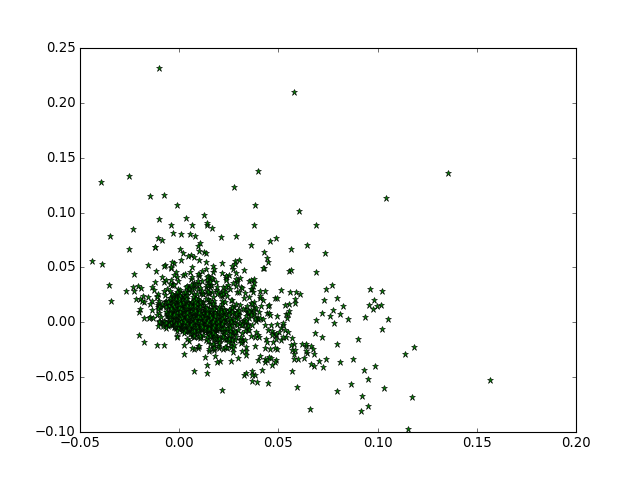

In [29]:
%matplotlib notebook

plt.plot(svd.U[:,0],svd.U[:,1],'*g')#anime

In [5]:
#recherche du top 1 du 1er vecteur
svd.VT[0,:].max() #recherche du max
svd.VT[0,:].argmax()#recherche de l'indice du max
works[svd.VT[0,:].argmax(),1]

'Princesse Mononoké'

In [6]:
#affichage du top 30 du 1er vecteur ligne de svd.VT
A=[svd.VT[0,i] for i in range(0, nb_items)]
A.sort()
B=svd.VT[0,:].tolist()
list_haut=[works[B.index(A[i]),1] for i in range(nb_items-30,nb_items)]
list_haut 

['Neon Genesis Evangelion',
 'Barakamon',
 'Code Geass: Hangyaku no Lelouch R2',
 'Fate/Zero',
 'Mahou Shoujo Madoka★Magica',
 'Cowboy Bebop',
 'Grave of the Fireflies',
 'Ghost in the Shell',
 'Baccano!',
 'Porco Rosso',
 'Kiki la petite sorcière',
 'Tengen Toppa Gurren Lagann',
 'FullMetal Alchemist',
 'Code Geass: Hangyaku no Lelouch',
 'Durarara!!',
 'Psycho-Pass',
 'Fullmetal Alchemist',
 "L'Attaque des Titans",
 'Toki wo Kakeru Shoujo',
 'Summer Wars',
 'Steins;Gate',
 'Death Note',
 'Le Château ambulant',
 'Fullmetal Alchemist: Brotherhood',
 'Nausicaä of the Valley of the Wind',
 'Les Enfants Loups : Ame & Yuki',
 'Le Château dans le ciel',
 'Mon voisin Totoro',
 'Le Voyage de Chihiro',
 'Princesse Mononoké']

# Un peu autre chose : DPP : determinential point process



Permet d'avoir des points moins proches les uns des autres pour permettre et proposer une meilleure variété d'animes

## Matrice de similarité

Méthode avec la mesure de cosine (cosinus)

In [12]:
#version bcp plus rapide
#TODO : enlever le calcul des éléments sur la diagonale qui ne sert à rien
#remplir la partie triangulaire inférieure par ce qu'il faut et 1 sur diag
#changer np.vdot en np.dot

import numpy as np
import pandas
from math import sqrt

#requiert une matrice SVD nommée SVD
#retourne une matrice de similarité similarity

def compute_similarity_coisine(SVD):
    nb_items = np.shape(SVD)[1]
    J = SVD.T.dot(SVD)
    D = np.sqrt(np.diag(J))
    similarity = J / D[:,np.newaxis].dot(D[np.newaxis,:])
    
    
    return similarity

similarity=compute_similarity_coisine(svd.VT)
similarity



array([[ 1.        ,  0.08471437, -0.56138472, ...,  0.14679545,
        -0.68534132,  0.00383582],
       [ 0.08471437,  1.        , -0.07371975, ...,  0.03701757,
        -0.0280354 ,  0.91589537],
       [-0.56138472, -0.07371975,  1.        , ..., -0.03505325,
         0.09011494,  0.15850288],
       ..., 
       [ 0.14679545,  0.03701757, -0.03505325, ...,  1.        ,
         0.11731634, -0.00233954],
       [-0.68534132, -0.0280354 ,  0.09011494, ...,  0.11731634,
         1.        ,  0.05507686],
       [ 0.00383582,  0.91589537,  0.15850288, ..., -0.00233954,
         0.05507686,  1.        ]])

Fonction effectuant le dpp en utilisant une matrice de similarité

In [8]:
def sample_k(items, L, k, max_nb_iterations=1000, rng=np.random):
    """
    Sample a list of k items from a DPP defined
    by the similarity matrix L. The algorithm
    is iterative and runs for max_nb_iterations.
    The algorithm used is from
    (Fast Determinantal Point Process Sampling withw
    Application to Clustering, Byungkon Kang, NIPS 2013)
    """
    initial = rng.choice(range(len(items)), size=k, replace=False)
    X = [False] * len(items)
    for i in initial:
        X[i] = True
    X = np.array(X)
    for i in range(max_nb_iterations):
        u = rng.choice(np.arange(len(items))[X])
        v = rng.choice(np.arange(len(items))[~X])
        Y = X.copy()
        Y[u] = False
        L_Y = L[Y, :]
        L_Y = L_Y[:, Y]
        L_Y_inv = np.linalg.inv(L_Y)

        c_v = L[v:v+1, :]
        c_v = c_v[:, v:v+1]
        b_v = L[Y, :]
        b_v = b_v[:, v:v+1]
        c_u = L[u:u+1, :]
        c_u = c_u[:, u:u+1]
        b_u = L[Y, :]
        b_u = b_u[:, u:u+1]

        p = min(1, c_v - np.dot(np.dot(b_v.T, L_Y_inv), b_v) /
                (c_u - np.dot(np.dot(b_u.T, L_Y_inv.T), b_u)))
        if rng.uniform() <= p:
            X = Y[:]
            X[v] = True
    return np.array(items)[X]  

In [19]:
#liste de 10 éléments choisis en utilisant la dpp
items = range(0,nb_items)
sampled_items = sample_k(items, similarity, 10)

In [20]:
#liste de 10 éléments choisis aléatoirement
import random
uniform_items = list(range(similarity.shape[0]))
random.shuffle(uniform_items)
uniform_items = uniform_items[:10]

In [21]:
sampled_items, uniform_items

(array([ 326,  831,  985, 2366, 2646, 3260, 3486, 4336, 4583, 7728]),
 [7712, 310, 791, 6908, 6082, 7415, 8227, 3307, 7189, 1420])

In [4]:
#comparaison de la somme obtenue des distances
from scipy.spatial.distance import pdist, squareform
pdist(svd.VT[:,sampled_items].T)


NameError: name 'svd' is not defined

In [22]:
(pdist(svd.VT[:,sampled_items].T)).sum()

0.98873002527137932

In [23]:
(pdist(svd.VT[:,uniform_items].T)).sum()

0.42570881437484043

<IPython.core.display.Javascript object>


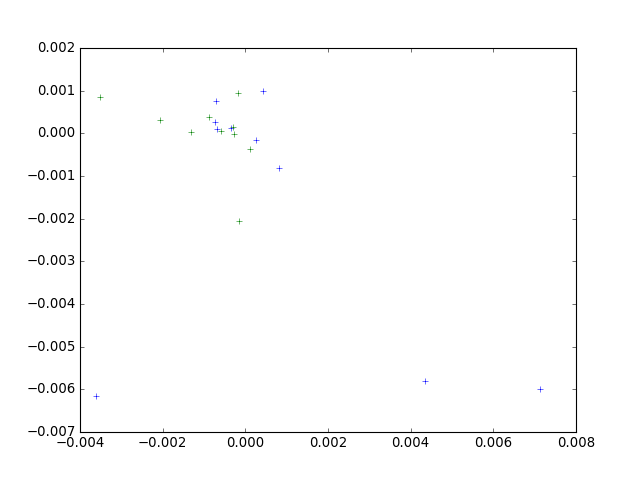

In [24]:
%matplotlib notebook
plt.clf()
plt.plot(svd.VT[0, sampled_items], svd.VT[1, sampled_items], '+b')
plt.plot(svd.VT[0, uniform_items], svd.VT[1, uniform_items], '+g')c

In [25]:
#comparaison des animes contenus dans chacune des listes
print('\n'.join(works[sampled_items,1]))

Romeo x Juliet
∀ Gundam
Dangoo - Samji
Attache-moi
Broken Blade 5
Utawarerumono Specials
Moi Taro Misaki
Erin
High School
C³ Special


In [26]:
print('\n'.join(works[uniform_items,1]))

Rose de Versailles Kids (la)
Choujigen Game Neptune: The Animation OVA
Katte ni Kaizou
Wellber no Monogatari: Sisters of Wellber
Ai Tenchi Muyou! Recaps
Shinryaku! Ika Musume: Ika Ice Tabena-ika?
Taisei Kensetsu: Bosporus Kaikyou Tunnel
No bra
Princess Lucia
The Magnificent Zorro


In [2]:
from scipy.spatial.distance import pdist, squareform

1 - squareform(pdist(svd.VT.T, metric='cosine'))

NameError: name 'svd' is not defined

# En cours, non fini, nbreux bugs


 Autre matrice de similarité en utilisant le Jaccard index

In [1]:
from mangaki.utils.svd import MangakiSVD
import numpy as np
import pandas 
from mangaki.utils.values import rating_values

ratings = pandas.read_csv('~/Bureau/ratings_mini.csv', header=None).as_matrix()
ratings
np.shape(ratings)
np.shape(ratings)[0]
ratings


array([[779, 462, 'wontsee'],
       [1154, 5507, 'willsee'],
       [772, 7991, 'like'],
       ..., 
       [1083, 7167, 'like'],
       [496, 7074, 'like'],
       [80, 114, 'like']], dtype=object)

In [ ]:
works=pandas.read_csv('../data/works.csv', header=None).as_matrix()

import numpy as np
import pandas
from math import sqrt


rating_values = {'favorite': 2, 'like': 2, 'dislike': -2, 'neutral': 0.1, 'willsee': 0.5, 'wontsee': -0.5}
Y=np.array([rating_values[rating] for rating in ratings[:,2]])
ratings[:,2]=Y.copy()
#matrice user*item entry
X=ratings[:,0:2]
nb_users=X[:,0].max()+1
nb_items=X[:,1].max()+1
entry=np.zeros([nb_users,nb_items])
curseur =0
while curseur != np.shape(ratings)[0]:
    entry[ratings[curseur,0],ratings[curseur,1]]=ratings[curseur,2]
print(entry)
        

In [3]:
#requiert une matrice user*item entry
#essayer de le faire matriciellement
#retourne une matrice de similarité similarity

def compute_similarity_jaccard(entry):
    
    nb_items = np.shape(entry)[1]
    for i in range(0,nb_items):
        for j in range(i+1,nb_items):
            vecteur=entry[:,i]*entry[:,j]
            nb_agree=vecteur.tolist().count(4)
            nb_disagree=vecteur.tolist.count(-4)
            similarity[i,j]=nb_agree/nb_disagree
            
    #partie triangulaire inf
    return similarity
similarity=compute_similarity_jaccard(svd.VT)


NameError: name 'svd' is not defined